In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import sys; print(sys.executable)

/usr/bin/python3


In [2]:
import os

# ── Paths ──────────────────────────────────────────────────────────────────
# Local
# DATA_DIR = "kaggle/input/"

# Kaggle — uncomment when running on Kaggle
DATA_DIR = "/kaggle/input/WiDSWorldWide_GlobalDathon26/"

# ── Load ───────────────────────────────────────────────────────────────────
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
meta  = pd.read_csv(os.path.join(DATA_DIR, "metaData.csv"))
sample_sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

print(f"train : {train.shape}")
print(f"test  : {test.shape}")
print(f"sample: {sample_sub.shape}")
train.head()

train : (221, 37)
test  : (95, 35)
sample: (95, 5)


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,...,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,...,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,...,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,...,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1
3,12044083,1,0.000000,1,67.631125,0.000000,0.000000,0.000000,4.228746,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20,5,8,60.953021,0
4,12052347,2,4.975273,0,35.632874,0.000000,0.000000,0.000000,3.600946,0.000000,...,0.000000,0.934634,0.934634,-0.000000,0.000000,21,5,7,44.990274,0


In [3]:
# Run once to install (already available on Kaggle)
!pip install -q lifelines

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.dpi"] = 110

# Feature column list (excludes id and targets)
FEATURE_COLS = [c for c in train.columns if c not in ("event_id", "time_to_hit_hours", "event")]
print(f"Feature columns ({len(FEATURE_COLS)}): {FEATURE_COLS}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.7 MB/s eta 0:00:00
Feature columns (34): ['num_perimeters_0_5h', 'dt_first_last_0_5h', 'low_temporal_resolution_0_5h', 'area_first_ha', 'area_growth_abs_0_5h', 'area_growth_rel_0_5h', 'area_growth_rate_ha_per_h', 'log1p_area_first', 'log1p_growth', 'log_area_ratio_0_5h', 'relative_growth_0_5h', 'radial_growth_m', 'radial_growth_rate_m_per_h', 'centroid_displacement_m', 'centroid_speed_m_per_h', 'spread_bearing_deg', 'spread_bearing_sin', 'spread_bearing_cos', 'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h', 'dist_slope_ci_0_5h', 'closing_speed_m_per_h', 'closing_speed_abs_m_per_h', 'projected_advance_m', 'dist_accel_m_per_h2', 'dist_fit_r2_0_5h', 'alignment_cos', 'alignment_abs', 'cross_track_component', 'along_track_speed', 'event_start_hour', 'event_start_dayofweek', 'event_start_month']


Train shape : (221, 37)
Test shape  : (95, 35)
Features    : 34

Null counts (train):
  No nulls ✓

area_growth_rel_0_5h == relative_growth_0_5h : True  ← drop one before modeling

────────────────────────────────────────
Target summary:
       time_to_hit_hours   event
count             221.00  221.00
mean               37.57    0.31
std                25.90    0.46
min                 0.00    0.00
25%                12.24    0.00
50%                43.11    0.00
75%                63.94    1.00
max                66.99    1.00

────────────────────────────────────────
Low-resolution (static) fires : 161 / 221 (72.9%)
  Event rate in static fires  : 20.5%
  Event rate in dynamic fires : 60.0%


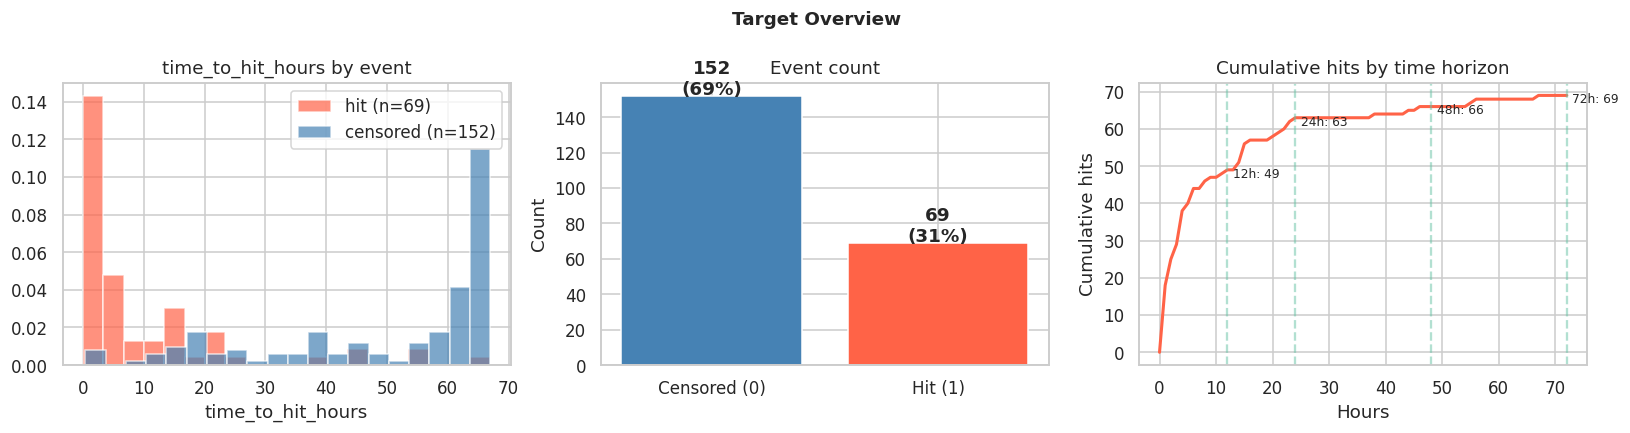

In [4]:
# ── Dataset overview ──────────────────────────────────────────────────────
print("=" * 60)
print(f"Train shape : {train.shape}")
print(f"Test shape  : {test.shape}")
print(f"Features    : {len(FEATURE_COLS)}")
print("=" * 60)

# Nulls
null_counts = train.isnull().sum()
print("\nNull counts (train):")
print("  No nulls ✓" if null_counts.sum() == 0 else null_counts[null_counts > 0].to_string())

# Duplicate columns check (area_growth_rel vs relative_growth)
dup = train["area_growth_rel_0_5h"].equals(train["relative_growth_0_5h"])
print(f"\narea_growth_rel_0_5h == relative_growth_0_5h : {dup}  ← drop one before modeling")

# Target summary
print(f"\n{'─'*40}")
print("Target summary:")
print(train[["time_to_hit_hours", "event"]].describe().round(2).to_string())

# Static fires
n_static = (train["low_temporal_resolution_0_5h"] == 1).sum()
static_event_rate = train.loc[train["low_temporal_resolution_0_5h"] == 1, "event"].mean()
dynamic_event_rate = train.loc[train["low_temporal_resolution_0_5h"] == 0, "event"].mean()
print(f"\n{'─'*40}")
print(f"Low-resolution (static) fires : {n_static} / {len(train)} ({100*n_static/len(train):.1f}%)")
print(f"  Event rate in static fires  : {100*static_event_rate:.1f}%")
print(f"  Event rate in dynamic fires : {100*dynamic_event_rate:.1f}%")

# ── Target distribution plot ───────────────────────────────────────────────
hits     = train[train["event"] == 1]["time_to_hit_hours"]
censored = train[train["event"] == 0]["time_to_hit_hours"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# time_to_hit distribution
axes[0].hist(hits,     bins=20, alpha=0.7, color="tomato",    label=f"hit (n={len(hits)})",      density=True)
axes[0].hist(censored, bins=20, alpha=0.7, color="steelblue", label=f"censored (n={len(censored)})", density=True)
axes[0].set_xlabel("time_to_hit_hours")
axes[0].set_title("time_to_hit_hours by event")
axes[0].legend()

# Event counts
axes[1].bar(["Censored (0)", "Hit (1)"], [len(censored), len(hits)], color=["steelblue", "tomato"])
for i, v in enumerate([len(censored), len(hits)]):
    axes[1].text(i, v + 1, f"{v}\n({100*v/len(train):.0f}%)", ha="center", fontweight="bold")
axes[1].set_title("Event count")
axes[1].set_ylabel("Count")

# Cumulative hit count by horizon
horizons = list(range(0, 73, 1))
cum_hits = [(hits <= h).sum() for h in horizons]
axes[2].plot(horizons, cum_hits, color="tomato", linewidth=2)
for h in [12, 24, 48, 72]:
    n = (hits <= h).sum()
    axes[2].axvline(h, linestyle="--", alpha=0.5)
    axes[2].annotate(f"{h}h: {n}", xy=(h, n), xytext=(h+1, n-2), fontsize=8)
axes[2].set_xlabel("Hours")
axes[2].set_ylabel("Cumulative hits")
axes[2].set_title("Cumulative hits by time horizon")

plt.suptitle("Target Overview", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

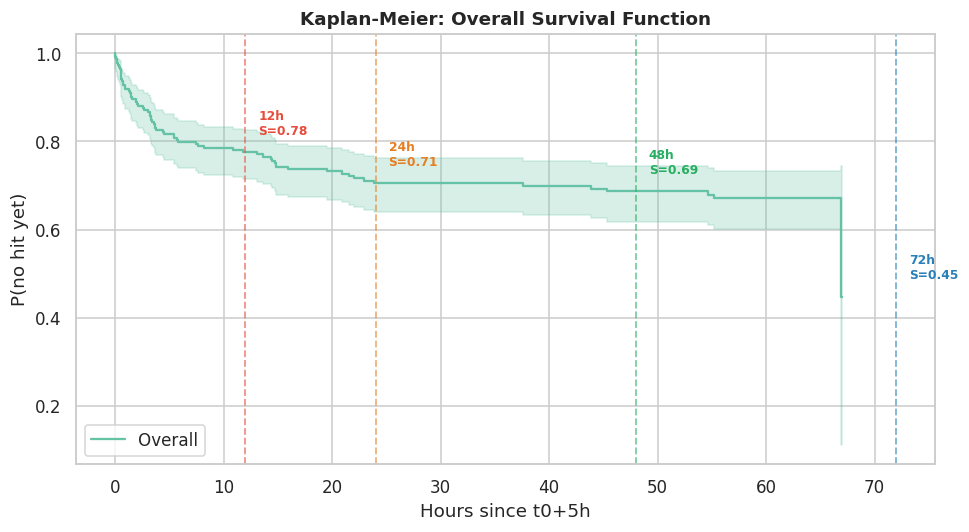

Survival probabilities → implied hit probabilities at each horizon:
  S(12h) = 0.775  →  P(hit by 12h) = 0.225
  S(24h) = 0.706  →  P(hit by 24h) = 0.294
  S(48h) = 0.687  →  P(hit by 48h) = 0.313
  S(72h) = 0.448  →  P(hit by 72h) = 0.552


In [5]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(9, 5))
kmf.fit(train["time_to_hit_hours"], event_observed=train["event"], label="Overall")
kmf.plot_survival_function(ax=ax, ci_show=True)

# Mark each evaluation horizon
for h, color in zip([12, 24, 48, 72], ["#e74c3c", "#e67e22", "#27ae60", "#2980b9"]):
    s = kmf.survival_function_at_times([h]).values[0]
    ax.axvline(h, linestyle="--", color=color, alpha=0.6, linewidth=1.2)
    ax.annotate(
        f"{h}h\nS={s:.2f}", xy=(h, s),
        xytext=(h + 1.2, s + 0.04),
        fontsize=8, color=color, fontweight="bold",
    )

ax.set_xlabel("Hours since t0+5h")
ax.set_ylabel("P(no hit yet)")
ax.set_title("Kaplan-Meier: Overall Survival Function", fontweight="bold")
plt.tight_layout()
plt.show()

print("Survival probabilities → implied hit probabilities at each horizon:")
for h in [12, 24, 48, 72]:
    s = kmf.survival_function_at_times([h]).values[0]
    print(f"  S({h:2d}h) = {s:.3f}  →  P(hit by {h:2d}h) = {1-s:.3f}")

Feature                               Hit median  Cens median    p-value  sig
------------------------------------------------------------------------------
num_perimeters_0_5h                        2.000        1.000     0.0000  ***
dt_first_last_0_5h                         1.170        0.000     0.0000  ***
low_temporal_resolution_0_5h               0.000        1.000     0.0000  ***
area_first_ha                             58.197      162.425     0.0089  ** 
area_growth_abs_0_5h                       0.000        0.000     0.0000  ***
area_growth_rel_0_5h                       0.000        0.000     0.0000  ***
area_growth_rate_ha_per_h                  0.000        0.000     0.0000  ***
log1p_area_first                           4.081        5.096     0.0089  ** 
log1p_growth                               0.000        0.000     0.0000  ***
log_area_ratio_0_5h                        0.000        0.000     0.0000  ***
relative_growth_0_5h                       0.000        0.000  

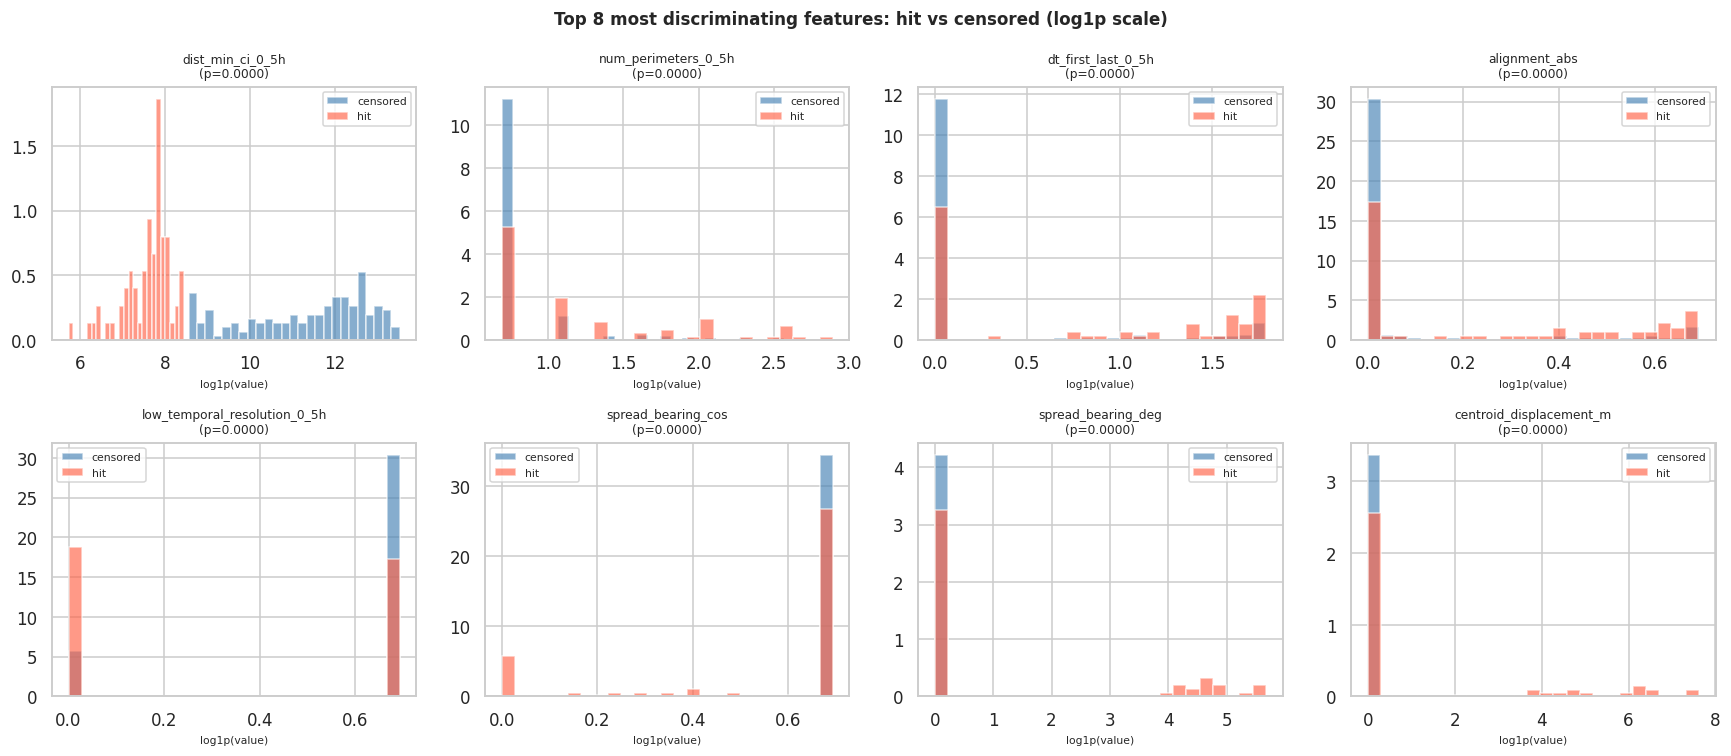

In [6]:
from scipy.stats import mannwhitneyu

hit_df  = train[train["event"] == 1]
cens_df = train[train["event"] == 0]

# ── Mann-Whitney U significance table ─────────────────────────────────────
print(f"{'Feature':<35} {'Hit median':>12} {'Cens median':>12} {'p-value':>10}  sig")
print("-" * 78)
mwu_results = {}
for feat in FEATURE_COLS:
    m_hit  = hit_df[feat].median()
    m_cens = cens_df[feat].median()
    _, p   = mannwhitneyu(hit_df[feat], cens_df[feat], alternative="two-sided")
    mwu_results[feat] = p
    sig = "***" if p < 0.001 else ("** " if p < 0.01 else ("*  " if p < 0.05 else "   "))
    print(f"{feat:<35} {m_hit:>12.3f} {m_cens:>12.3f} {p:>10.4f}  {sig}")

# ── Distribution plots for top discriminating features ────────────────────
top_feats = sorted(mwu_results, key=mwu_results.get)[:8]  # lowest p-values

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()
for ax, feat in zip(axes, top_feats):
    vals_hit  = np.log1p(hit_df[feat].clip(lower=0))
    vals_cens = np.log1p(cens_df[feat].clip(lower=0))
    ax.hist(vals_cens, bins=25, alpha=0.65, label="censored", color="steelblue", density=True)
    ax.hist(vals_hit,  bins=25, alpha=0.65, label="hit",      color="tomato",    density=True)
    ax.set_title(f"{feat}\n(p={mwu_results[feat]:.4f})", fontsize=8)
    ax.set_xlabel("log1p(value)", fontsize=7)
    ax.legend(fontsize=7)

plt.suptitle("Top 8 most discriminating features: hit vs censored (log1p scale)",
             fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()

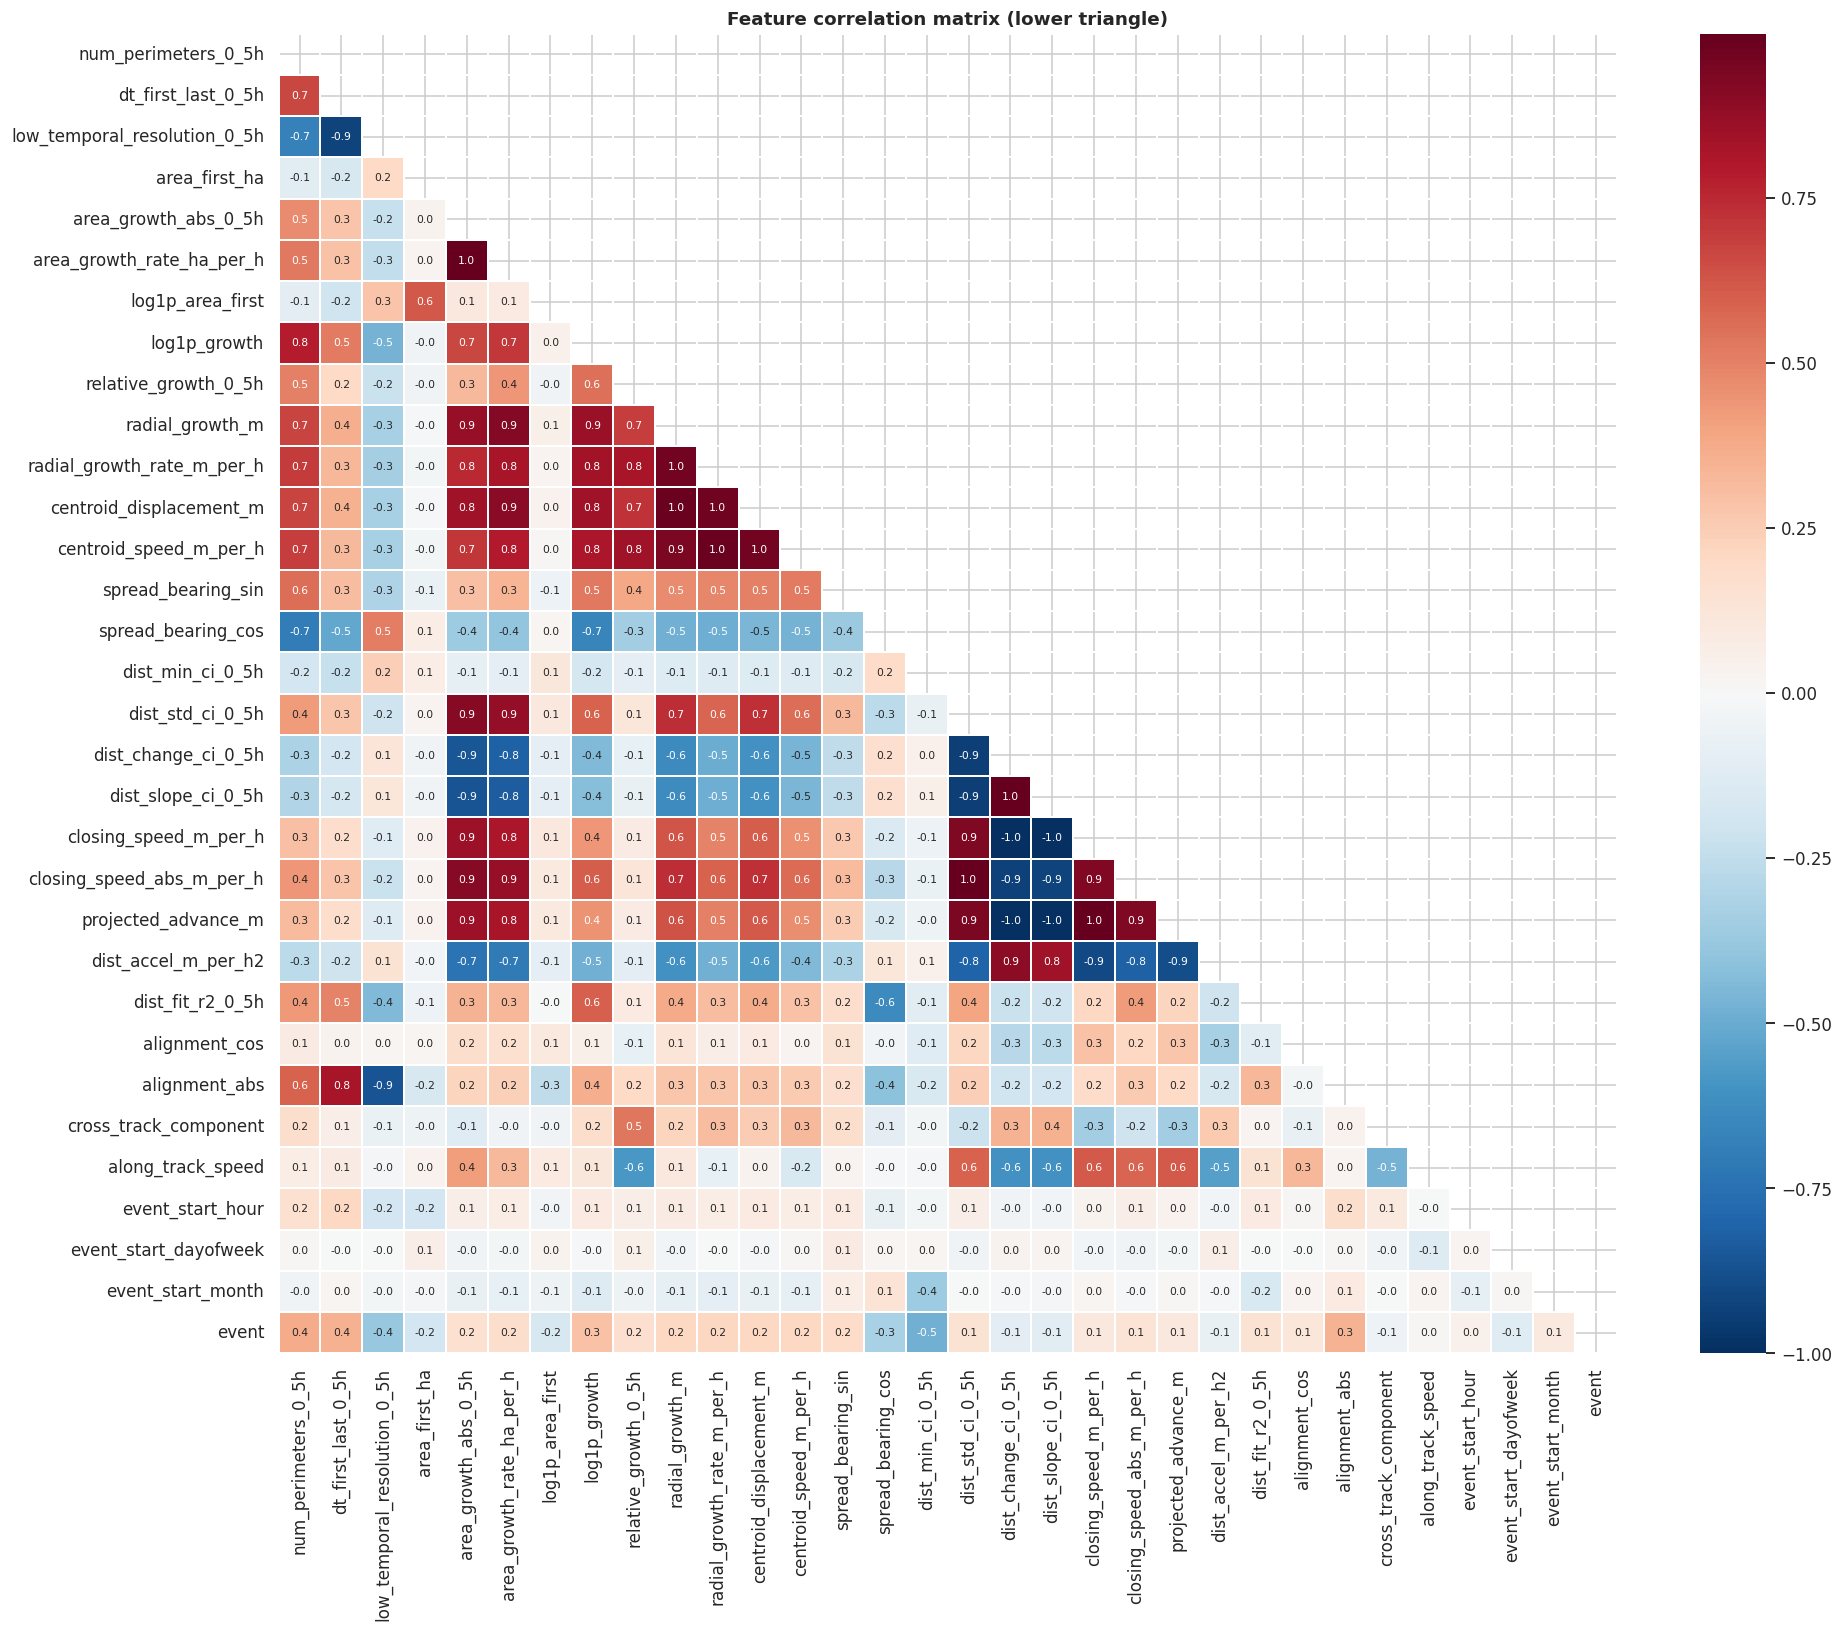

Top 12 features by |correlation| with event:
dist_min_ci_0_5h                0.481
low_temporal_resolution_0_5h    0.379
num_perimeters_0_5h             0.371
dt_first_last_0_5h              0.353
alignment_abs                   0.349
spread_bearing_cos              0.323
log1p_growth                    0.293
radial_growth_rate_m_per_h      0.215
radial_growth_m                 0.209
centroid_speed_m_per_h          0.209
centroid_displacement_m         0.208
spread_bearing_sin              0.188


In [7]:
# Drop known redundant columns (duplicates / encoded variants already present)
REDUNDANT = [
    "area_growth_rel_0_5h",   # identical to relative_growth_0_5h
    "log_area_ratio_0_5h",    # ~= log1p_growth - log1p_area_first (derivative)
    "spread_bearing_deg",     # already encoded via spread_bearing_sin/cos
]
corr_feats = [f for f in FEATURE_COLS if f not in REDUNDANT]

corr_matrix = train[corr_feats + ["event"]].corr()

fig, ax = plt.subplots(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".1f",
    cmap="RdBu_r", center=0, linewidths=0.3, ax=ax,
    annot_kws={"size": 7},
)
ax.set_title("Feature correlation matrix (lower triangle)", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# Top correlations with the event target
event_corr = corr_matrix["event"].drop("event").abs().sort_values(ascending=False)
print("Top 12 features by |correlation| with event:")
print(event_corr.head(12).round(3).to_string())

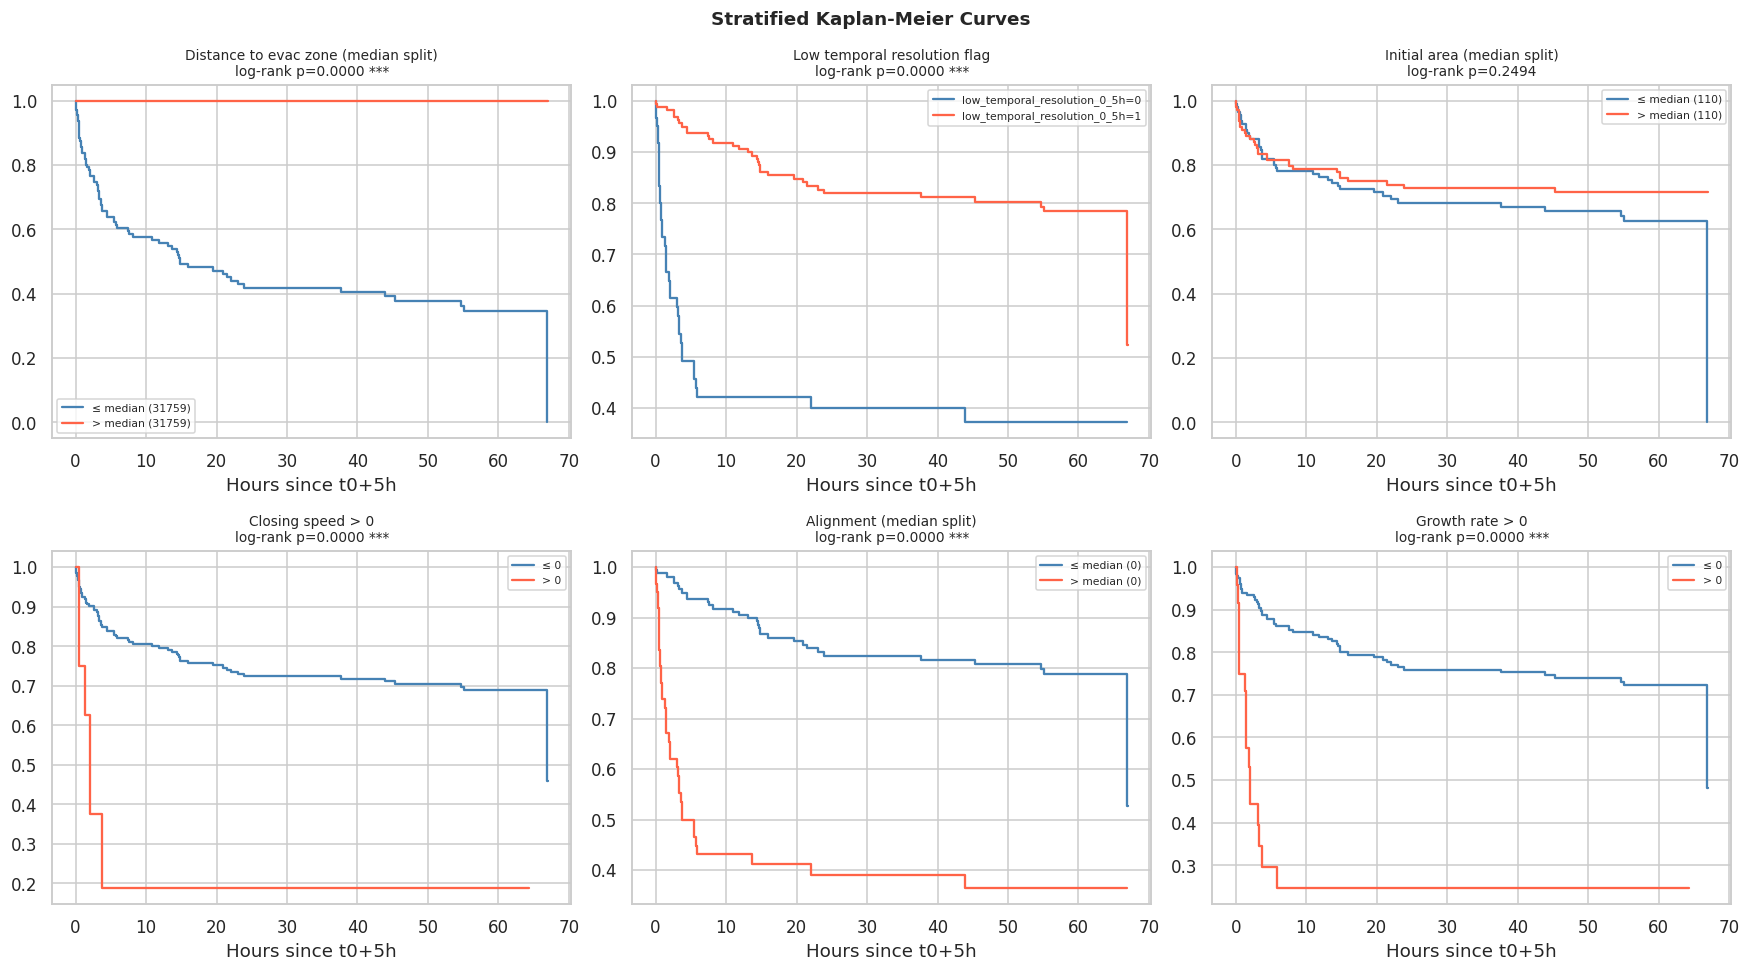

In [8]:
# Stratified KM curves — one panel per key feature split
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

strat_configs = [
    ("dist_min_ci_0_5h",             "Distance to evac zone (median split)", "median"),
    ("low_temporal_resolution_0_5h", "Low temporal resolution flag",          "binary"),
    ("area_first_ha",                "Initial area (median split)",           "median"),
    ("closing_speed_m_per_h",        "Closing speed > 0",                     "nonzero"),
    ("alignment_abs",                "Alignment (median split)",              "median"),
    ("area_growth_rate_ha_per_h",    "Growth rate > 0",                       "nonzero"),
]

kmf_s = KaplanMeierFitter()
for ax, (feat, title, split_type) in zip(axes, strat_configs):
    if split_type == "median":
        threshold = train[feat].median()
        grp_lo = train[feat] <= threshold
        grp_hi = ~grp_lo
        labels = [f"≤ median ({threshold:.0f})", f"> median ({threshold:.0f})"]
    elif split_type == "binary":
        grp_lo = train[feat] == 0
        grp_hi = train[feat] == 1
        labels = [f"{feat}=0", f"{feat}=1"]
    elif split_type == "nonzero":
        grp_lo = train[feat] <= 0
        grp_hi = train[feat] > 0
        labels = [f"≤ 0", f"> 0"]

    for grp, label, color in zip([grp_lo, grp_hi], labels, ["steelblue", "tomato"]):
        sub = train[grp]
        kmf_s.fit(sub["time_to_hit_hours"], event_observed=sub["event"], label=label)
        kmf_s.plot_survival_function(ax=ax, ci_show=False, color=color)

    lr = logrank_test(
        train.loc[grp_lo, "time_to_hit_hours"], train.loc[grp_hi, "time_to_hit_hours"],
        event_observed_A=train.loc[grp_lo, "event"],
        event_observed_B=train.loc[grp_hi, "event"],
    )
    sig = " ***" if lr.p_value < 0.001 else (" **" if lr.p_value < 0.01 else (" *" if lr.p_value < 0.05 else ""))
    ax.set_title(f"{title}\nlog-rank p={lr.p_value:.4f}{sig}", fontsize=9)
    ax.set_xlabel("Hours since t0+5h")
    ax.legend(fontsize=7)

plt.suptitle("Stratified Kaplan-Meier Curves", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

In [9]:
def engineer_features(df):
    df = df.copy()

    # ── 2.1 Drop redundant / noise columns ────────────────────────────────
    DROP_COLS = [
        # Exact duplicate
        "area_growth_rel_0_5h",        # identical to relative_growth_0_5h
        # Redundant encodings
        "spread_bearing_deg",          # encoded by sin/cos
        "log_area_ratio_0_5h",         # derivable from log1p_growth - log1p_area_first
        # Non-significant (EDA: p > 0.05)
        "closing_speed_m_per_h",       # signed speed; only abs speed matters (p=0.43)
        "dist_change_ci_0_5h",         # p=0.44
        "projected_advance_m",         # p=0.44
        "dist_accel_m_per_h2",         # p=0.18
        "alignment_cos",               # p=0.23; use alignment_abs only
        "along_track_speed",           # p=0.35
        "cross_track_component",       # p=0.07
        "event_start_hour",            # p=0.83
        "event_start_dayofweek",       # p=0.08
        "event_start_month",           # p=0.28
    ]
    df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

    # ── 2.2 Tier 1: High-priority derived features ─────────────────────────

    # Log-transform of dominant predictor (53x median difference, extreme right skew)
    df["log_dist_min"] = np.log1p(df["dist_min_ci_0_5h"])

    # Estimated hours to reach evac zone at current absolute closing speed
    # dist (m) / speed (m/h) = hours; clip to 72h max horizon
    df["time_to_reach_h"] = (
        df["dist_min_ci_0_5h"] / df["closing_speed_abs_m_per_h"].clip(lower=1e-6)
    ).clip(upper=72.0)

    # Dynamic fire indicator (positive direction: dynamic=1 hits at 60% vs static=1 at 20.5%)
    df["is_dynamic"] = (1 - df["low_temporal_resolution_0_5h"]).astype(int)

    # ── 2.3 Tier 2: Composite features ────────────────────────────────────

    # Distance adjusted for fire size (accounts for inverted area finding)
    df["dist_per_log_area"] = df["log_dist_min"] / (np.log1p(df["area_first_ha"]) + 1e-6)

    # Combined threat: abs closing speed × directional alignment / distance
    df["effective_threat"] = (
        df["closing_speed_abs_m_per_h"] * df["alignment_abs"]
        / (df["dist_min_ci_0_5h"].clip(lower=1.0))
    )

    return df


train_fe = engineer_features(train)
test_fe  = engineer_features(test)

print(f"Columns before : {train.shape[1] - 2}")
print(f"Columns after  : {train_fe.shape[1] - 2}")

new_feats = ["log_dist_min", "time_to_reach_h", "is_dynamic", "dist_per_log_area", "effective_threat"]
print(f"\nNew feature stats (train):")
print(train_fe[new_feats].describe().round(3).to_string())

Columns before : 35
Columns after  : 27

New feature stats (train):
       log_dist_min  time_to_reach_h  is_dynamic  dist_per_log_area  effective_threat
count       221.000          221.000     221.000            221.000           221.000
mean         10.179           71.329       0.271              5.247             0.001
std           2.138            5.965       0.446             23.231             0.009
min           5.730            7.904       0.000              1.042             0.000
25%           7.995           72.000       0.000              1.599             0.000
50%          10.366           72.000       0.000              2.133             0.000
75%          12.207           72.000       1.000              3.155             0.000
max          13.538           72.000       1.000            330.555             0.114


In [10]:
# Final feature set — all columns except id and targets
FEATURE_COLS_FE = [
    c for c in train_fe.columns
    if c not in ("event_id", "time_to_hit_hours", "event")
]

print(f"Final feature count: {len(FEATURE_COLS_FE)}")
print("\nFeatures:")
for f in FEATURE_COLS_FE:
    print(f"  {f}")

# Sanity checks on new features
print("\n── Sanity checks ──")
print(f"  Nulls in train_fe : {train_fe[FEATURE_COLS_FE].isnull().sum().sum()}")
print(f"  Nulls in test_fe  : {test_fe[FEATURE_COLS_FE].isnull().sum().sum()}")
print(f"  Inf in train_fe   : {np.isinf(train_fe[FEATURE_COLS_FE]).sum().sum()}")

# Check new features vs event (quick MWU)
print("\n── New feature significance vs event ──")
from scipy.stats import mannwhitneyu
h_df = train_fe[train_fe["event"] == 1]
c_df = train_fe[train_fe["event"] == 0]
for f in ["log_dist_min", "time_to_reach_h", "is_dynamic", "dist_per_log_area", "effective_threat"]:
    _, p = mannwhitneyu(h_df[f], c_df[f], alternative="two-sided")
    print(f"  {f:<25}  hit_med={h_df[f].median():>10.3f}  cens_med={c_df[f].median():>10.3f}  p={p:.4f}")

Final feature count: 26

Features:
  num_perimeters_0_5h
  dt_first_last_0_5h
  low_temporal_resolution_0_5h
  area_first_ha
  area_growth_abs_0_5h
  area_growth_rate_ha_per_h
  log1p_area_first
  log1p_growth
  relative_growth_0_5h
  radial_growth_m
  radial_growth_rate_m_per_h
  centroid_displacement_m
  centroid_speed_m_per_h
  spread_bearing_sin
  spread_bearing_cos
  dist_min_ci_0_5h
  dist_std_ci_0_5h
  dist_slope_ci_0_5h
  closing_speed_abs_m_per_h
  dist_fit_r2_0_5h
  alignment_abs
  log_dist_min
  time_to_reach_h
  is_dynamic
  dist_per_log_area
  effective_threat

── Sanity checks ──
  Nulls in train_fe : 0
  Nulls in test_fe  : 0
  Inf in train_fe   : 0

── New feature significance vs event ──
  log_dist_min               hit_med=     7.796  cens_med=    11.766  p=0.0000
  time_to_reach_h            hit_med=    72.000  cens_med=    72.000  p=0.0100
  is_dynamic                 hit_med=     1.000  cens_med=     0.000  p=0.0000
  dist_per_log_area          hit_med=     1.724  

In [11]:
!pip install -q scikit-survival  
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings("ignore")

HORIZONS       = [12, 24, 48, 72]
BRIER_HORIZONS = [24, 48, 72]
BRIER_WEIGHTS  = {24: 0.3, 48: 0.4, 72: 0.3}

# ── Survival target (structured array) ────────────────────────────────────
X = train_fe[FEATURE_COLS_FE].values
y = np.array(
    [(bool(e), t) for e, t in zip(train_fe["event"], train_fe["time_to_hit_hours"])],
    dtype=[("event", bool), ("time", float)],
)

def predict_probs(surv_fns, horizon):
    """Evaluate 1 - S(t), clipped to each function's domain."""
    return np.array([1 - fn(min(horizon, fn.domain[1])) for fn in surv_fns])

def competition_brier(events, times, probs, horizon):
    """Competition-specific Brier score (excludes fires censored before horizon)."""
    events   = np.asarray(events, dtype=bool)
    times    = np.asarray(times,  dtype=float)
    probs    = np.asarray(probs,  dtype=float)
    outcomes = np.where(events & (times <= horizon), 1.0, 0.0)
    include  = events | (times >= horizon)
    if include.sum() == 0:
        return np.nan
    return np.mean((outcomes[include] - probs[include]) ** 2)

# ── Alpha grid search via 5-fold CV ───────────────────────────────────────
alphas = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
skf    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"{'alpha':>8} | {'C-index':>8} | {'B@24h':>7} | {'B@48h':>7} | {'B@72h':>7} | {'WgtBrier':>9} | {'Hybrid':>8}")
print("─" * 75)

alpha_scores = {}
for alpha in alphas:
    fold_metrics = []
    for tr_idx, va_idx in skf.split(X, train_fe["event"]):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        ev_va = train_fe["event"].iloc[va_idx].values
        t_va  = train_fe["time_to_hit_hours"].iloc[va_idx].values

        # Scale features (fit on train fold only)
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_va_s = scaler.transform(X_va)

        model = CoxPHSurvivalAnalysis(alpha=alpha)
        model.fit(X_tr_s, y_tr)

        risk     = model.predict(X_va_s)
        c_idx    = concordance_index_censored(y_va["event"], y_va["time"], risk)[0]

        surv_fns = model.predict_survival_function(X_va_s)
        bs = {h: competition_brier(ev_va, t_va, predict_probs(surv_fns, h), h)
              for h in BRIER_HORIZONS}

        w_bs   = sum(BRIER_WEIGHTS[h] * bs[h] for h in BRIER_HORIZONS)
        hybrid = 0.3 * c_idx + 0.7 * (1 - w_bs)
        fold_metrics.append((c_idx, bs[24], bs[48], bs[72], w_bs, hybrid))

    means = np.mean(fold_metrics, axis=0)
    alpha_scores[alpha] = means[5]
    print(f"{alpha:>8.2f} | {means[0]:>8.3f} | {means[1]:>7.3f} | {means[2]:>7.3f} | {means[3]:>7.3f} | {means[4]:>9.3f} | {means[5]:>8.3f}")

best_alpha = max(alpha_scores, key=alpha_scores.get)
print(f"\nBest alpha = {best_alpha}  (hybrid = {alpha_scores[best_alpha]:.3f})")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 13.4 MB/s eta 0:00:00
   alpha |  C-index |   B@24h |   B@48h |   B@72h |  WgtBrier |   Hybrid
───────────────────────────────────────────────────────────────────────────
    0.01 |    0.897 |   0.070 |   0.068 |   0.068 |     0.069 |    0.921
    0.05 |    0.876 |   0.083 |   0.083 |   0.070 |     0.079 |    0.907
    0.10 |    0.873 |   0.087 |   0.086 |   0.072 |     0.082 |    0.905
    0.50 |    0.873 |   0.084 |   0.080 |   0.062 |     0.076 |    0.909
    1.00 |    0.880 |   0.082 |   0.078 |   0.059 |     0.073 |    0.913
    5.00 |    0.891 |   0.083 |   0.078 |   0.051 |     0.072 |    0.917
   10.00 |    0.902 |   0.081 |   0.075 |   0.046 |     0.068 |    0.923

Best alpha = 10.0  (hybrid = 0.923)


In [12]:
# Fit scaler + final model on full training set
final_scaler = StandardScaler()
X_scaled     = final_scaler.fit_transform(X)

final_model  = CoxPHSurvivalAnalysis(alpha=best_alpha)
final_model.fit(X_scaled, y)

X_test_arr    = test_fe[FEATURE_COLS_FE].values
X_test_scaled = final_scaler.transform(X_test_arr)
surv_fns_test = final_model.predict_survival_function(X_test_scaled)

print(f"Final model fitted  — alpha={best_alpha}")
print(f"Test samples        : {len(surv_fns_test)}")

Final model fitted  — alpha=10.0
Test samples        : 95


In [13]:
submission_cph = sample_sub.copy()
for h in HORIZONS:
    submission_cph[f"prob_{h}h"] = predict_probs(surv_fns_test, h)

# Enforce monotonicity across horizons
for prev_h, h in zip(HORIZONS, HORIZONS[1:]):
    submission_cph[f"prob_{h}h"] = submission_cph[[f"prob_{prev_h}h", f"prob_{h}h"]].max(axis=1)

# ── Sanity checks ─────────────────────────────────────────────────────────
print("── Sanity checks ──")
print(f"  Shape          : {submission_cph.shape}")
print(f"  Nulls          : {submission_cph.isnull().sum().sum()}")
prob_cols = [f"prob_{h}h" for h in HORIZONS]
in_range  = ((submission_cph[prob_cols] >= 0) & (submission_cph[prob_cols] <= 1)).all().all()
print(f"  Probs in [0,1] : {in_range}")
mono_ok = (
    (submission_cph["prob_24h"] >= submission_cph["prob_12h"]) &
    (submission_cph["prob_48h"] >= submission_cph["prob_24h"]) &
    (submission_cph["prob_72h"] >= submission_cph["prob_48h"])
).all()
print(f"  Monotone       : {mono_ok}")

submission_cph.to_csv("submission_cph_baseline.csv", index=False)
print("\nSaved → submission_cph_baseline.csv")
submission_cph.head(10)

── Sanity checks ──
  Shape          : (95, 5)
  Nulls          : 0
  Probs in [0,1] : True
  Monotone       : True

Saved → submission_cph_baseline.csv


,event_id,prob_12h,prob_24h,prob_48h,prob_72h
0,10662602,0.017816,0.032253,0.037886,0.079149
1,13353600,0.351268,0.545796,0.605344,0.862610
2,13942327,0.073792,0.130471,0.151849,0.296451
3,16112781,0.382277,0.584611,0.644765,0.890256
4,17132808,0.215239,0.357274,0.405924,0.671022
5,17445696,0.014126,0.025612,0.030103,0.063171
6,17599982,0.005893,0.010722,0.012619,0.026747
7,18750374,0.261338,0.424461,0.478381,0.750789
8,21365245,0.033730,0.060659,0.071067,0.145625
9,23634840,0.683292,0.877167,0.915442,0.994877
